<H1>Predicting Flight Delays</H1>
<H3>by Michael Klear</H3>
Using <a href='http://stat-computing.org/dataexpo/2009/the-data.html'>this ASA dataset</a> of historic flights, I built a boosted regression model to estimate flight tardiness.<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


I use these functions to evaluate my model performance. I group delays into several different categories (details in docstring for function assign_delay_group).

In [2]:
def assign_delay_group(arrival_delay):
    '''Takes an arrival delay in minutes and returns a list of 
    group numbers. The groups correspond to the following encoding:
    == 0 if less than 30 minutes late (on time), 
    == 1 if 30-45 minutes late, 
    == 2 if 45-60 min late, 
    == 3 if 60-90, 
    == 4 if 90-120, 
    == 5 if 120-180,
    == 6 if 180-240,
    == 7 if more than 240
    '''
    d = int(arrival_delay)
    if d < 30:
        return 0
    if 30 <= d < 45:
        return 1
    if 45 <= d < 60:
        return 2
    if 60 <= d < 90:
        return 3
    if 90 <= d < 120:
        return 4
    if 120 <= d < 180:
        return 5
    if 180 <= d < 240:
        return 6
    if 240 <= d:
        return 7
    else:
        raise Exception('Error: unrecognized input')

def eval_performance(Y_, Y_true):
    """Takes a list of predicted arrival delays (Y_) and a matching list of actual
    arrival delays (Y_true) and evaluates them based on delay groups.
    """
    Y_ = list(pd.Series(Y_).apply(assign_delay_group))
    Y_true = list(pd.Series(Y_true).apply(assign_delay_group))
    results = pd.DataFrame()
    results['true_group'] = Y_true
    results['predicted_group'] = Y_
    results['correct'] = np.where(results.true_group == results.predicted_group, 1, 0)
    results['off_by'] = np.abs(results.true_group - results.predicted_group)
    results[results.correct==0].true_group.hist(bins=7);
    plt.title('True Arrival Groups of Misclassified Flights');
    plt.xlabel('True Arrival Group');
    plt.ylabel('Number of Misclassified Flights')
    plt.show();
    print('\n accuracy score: ', results.correct.sum()/len(results))
    results[results.correct==0].off_by.hist(bins=7);
    plt.title('"Off By" Numer of Groups for Misclassified Flights');
    plt.xlabel('Off By Number of Groups');
    plt.ylabel('Number of Misclassified Flights');
    plt.show();
    
    print('\n Portion of Predictions Off By More than One Group: ', (len(results[results.off_by >= 2])/len(results)))

I train my model on the month of April 2005 and test in on April 2006. I have modified the dataset to include latitude/longitude coordinates for each of the airports. I have also dropped diverted and cancelled flights.

In [3]:
apr05 = pd.read_csv('April05_cds.csv')
apr06 = pd.read_csv('April06_cds.csv')

In [4]:
apr05.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'org_latitude', 'org_longitude', 'dest_latitude', 'dest_longitude',
       'lat_dir', 'long_dir'],
      dtype='object')

In [5]:
delays = [
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

#We can see the complex relationship between these delay type columns and total delay.
#I use a boosted decision tree model to help gather subtle information from these interactions.
apr05[apr05.DepDelay > 30][['DepDelay'] + delays].head()

,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
21,54.0,0,0,17,0,54
46,66.0,6,0,0,0,55
48,54.0,0,0,2,0,50
57,33.0,22,0,0,0,0
58,53.0,0,0,12,0,53


In [6]:
#These are all of our features
fts = delays + [
    'DayOfWeek',
    'DepTime',
    'Distance',
    'CRSElapsedTime',
    'DepDelay',
    'TaxiOut',
    'org_latitude',
    'org_longitude',
    'dest_latitude',
    'dest_longitude',
    'lat_dir',
    'long_dir'
]

X_train = pd.concat([apr05[fts], pd.get_dummies('UniqueCarrier')], axis=1)
X_test = pd.concat([apr06[fts], pd.get_dummies('UniqueCarrier')], axis=1)

<H2>Arrival Delay Varies from Departure Delay</H2><br>
One might think that arrival delay maps directly to departure delay. A simple model would be to simply predict that the arrival delay is equal to the departure delay. Let's see how this "null" model performs:

Null Model Performance (arrival delay = departure delay): All Flights April 2006 



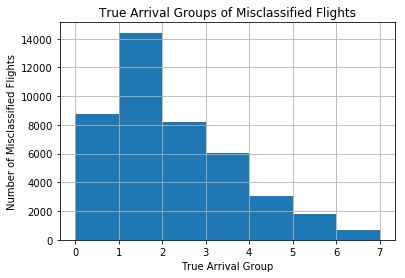


 accuracy score:  0.925496522525


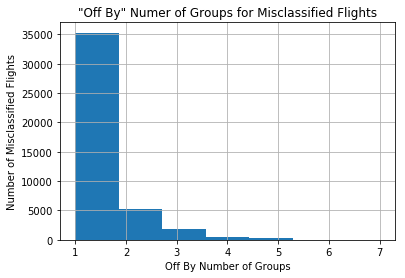


 Portion of Predictions Off By More than One Group:  0.013433889890915637


In [7]:
print('Null Model Performance (arrival delay = departure delay): All Flights April 2006 \n')
eval_performance(apr06.DepDelay, apr06.ArrDelay)

We can see that this model isn't terrible. It misclassifies roughly 7.5% of arrivals in terms of their actual delay groups.<br>
It does have some problems. More than 1% of all the predictions are off by more than one delay group, meaning that these predictions could cause problems for travelers or customer service agents relying on this model.

<H2>My Model: Break Flight Time into 3 Components</H2><br>
To improve on the "null model," I built several components into my prediction. The source of variance between departure delay and arrival delay is the difference between scheduled total flight time ("CRSElapsedTime") and the true flight time. This has three components: 1. TaxiOut (the time between departure and takeoff), 2. AirTime (the time from wheels up to touchdown), and 3. TaxiIn (the time between landing and arrival at gate.)<br>
Because the taxiout occurs immediately after departure, my model uses the true value for the first component. I then use two seperate xgboost models to predict flight time and taxi in time, and use the sum of these three components to predict the arrival time in my model.

In [8]:
#Put data into xgboost data matrices
dtrain_air = xgb.DMatrix(X_train, label=apr05['AirTime'])
dtest_air = xgb.DMatrix(X_test, label=apr06['AirTime'])

In [9]:
#Component 2: Predict Airtime
param = {
    'max_depth': 7, 
    'eta': .04, 
    'silent': 0, 
    'objective': 
    'reg:linear', 
    'alpha': 1,
    'lambda': 2,
    'nthread':4,
    'eval_metric':'rmse'
}

plst = param.items()
num_round = 635 #No additional gains after this point
evallist = [(dtest_air, 'eval'), (dtrain_air, 'train')]
air_est = xgb.train(plst, dtrain_air, num_round, evallist, verbose_eval=False) 

In [10]:
#Roughly estimate arrival time to help predict taxi in time.
apr05['est_act_arrtime'] = apr05.CRSArrTime + apr05.DepDelay
apr06['est_act_arrtime'] = apr06.CRSArrTime + apr06.DepDelay

In [11]:
#I reason that fewer factors influence taxi in time; I reduce features to include only destination location
# (scheduled) arrival time and day of week, as well as carrier (airline)
fts_tax = [
    'DayOfWeek',
    'est_act_arrtime',
    'dest_latitude',
    'dest_longitude'
]

Xtax_train = pd.concat([apr05[fts], pd.get_dummies('UniqueCarrier')], axis=1)
Xtax_test = pd.concat([apr06[fts], pd.get_dummies('UniqueCarrier')], axis=1)

In [12]:
dtrain_tax = xgb.DMatrix(Xtax_train, label=apr05['TaxiIn'])
dtest_tax = xgb.DMatrix(Xtax_test, label=apr06['TaxiIn'])

param = {
    'max_depth': 4, 
    'eta': .04, 
    'silent': 0, 
    'objective': 
    'reg:linear', 
    #'alpha': 1,
    #'lambda': 2,
    'nthread':4,
    'eval_metric':'rmse'
}

plst = param.items()
num_round = 700
evallist = [(dtest_tax, 'eval'), (dtrain_tax, 'train')]
tax_est = xgb.train(plst, dtrain_tax, num_round, evallist, verbose_eval=False)

Finally, I put my models (trained on April 2005 data) to use and make some predictions on the April 2006 arrival times.

Three-Component Predictions with Boosted Decision Trees Performance: All Flights April 2006 



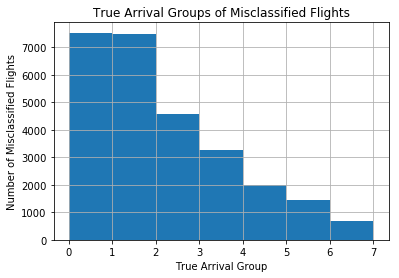


 accuracy score:  0.953302476295


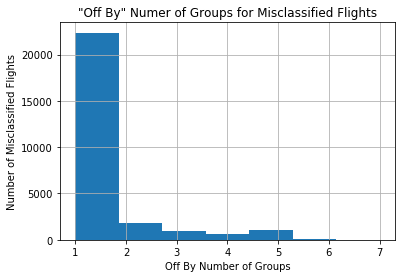


 Portion of Predictions Off By More than One Group:  0.007993519329499859


In [13]:
est_elapsed_time = apr06.TaxiOut + air_est.predict(dtest_air) + tax_est.predict(dtest_tax)
preds = apr06.DepDelay + est_elapsed_time - apr06.CRSElapsedTime
print('Three-Component Predictions with Boosted Decision Trees Performance: All Flights April 2006 \n')
eval_performance(preds, apr06.ArrDelay)

<H3>Evaluation</H3><br>
My three-component model eliminated more than one-third of the misplaced arrival groups. It also reduced the number of predicted arrival times off by more than one group to less than .8% of all predictions.<br>
This shows that my approach works, but there is still alot of room for improvement. Honestly, I spent most of my time tuning up the airtime component and the taxi in time estimation is pretty lousy. With more work, I think I can improve the taxi in time estimation and greatly improve the overall performance of my model.